In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd
pd.options.display.float_format = '{:.1f}'.format

import json
import glob
import os
import re

# kNN

In [2]:
base = "/algoDaten/zeitz/projects/valentin_base_dir/Experiments/NearestNeighbors/"

In [4]:
selections = []
queries = []

for (p, b) in [(12, 20), (14, 25)]:
    for algo in ['Dij', 'BCH', 'BCCH*', 'CCH*']:
        data = pd.read_csv(base + f"SEA21_improved/POIs/b{b}_p{p}_{algo.replace('*', '')}.index.csv")
        data['algo'] = algo
        data['P_exp'] = p
        data['B_exp'] = b
        selections.append(data)
        data = pd.read_csv(base + f"SEA21_improved/POIs/b{b}_p{p}_{algo.replace('*', '')}.query.csv")
        data['algo'] = algo
        data['P_exp'] = p
        data['B_exp'] = b
        queries.append(data)
    for algo in ['BCCH', 'CCH']:
        data = pd.read_csv(base + f"SEA21/POIs/b{b}_p{p}_{algo}.index.csv")
        data['algo'] = algo
        data['P_exp'] = p
        data['B_exp'] = b
        selections.append(data)
        data = pd.read_csv(base + f"SEA21/POIs/b{b}_p{p}_{algo}.query.csv")
        data['algo'] = algo
        data['P_exp'] = p
        data['B_exp'] = b
        queries.append(data)
        
selections = pd.concat(selections, ignore_index=True)
queries = pd.concat(queries, ignore_index=True)
selections['time'] = selections['time'] / 1000000
selections['space'] = selections['space'] / (2**20)
queries['time'] = queries['time'] / 1000000

In [6]:
selections.groupby(['P_exp', 'algo']).mean()[['space', 'time']].unstack(0).reindex(['Dij', 'BCH', 'BCCH', 'CCH', 'CCH*']).swaplevel(axis='columns').sort_index(axis='columns')

P_exp    12          14       
      space  time space   time
algo                          
Dij     0.0   0.2   0.0    0.3
BCH    72.4 123.2  83.6  464.3
BCCH   85.5 486.0 134.9 1901.0
CCH    68.7  12.5  68.7   13.8
CCH*   68.7  12.4  68.7   13.9

In [5]:
(queries.groupby(['algo', 'max_pois', 'P_exp']).mean()['time'] / 1000).unstack().unstack().reindex(['Dij', 'BCH', 'BCCH', 'CCH', 'CCH*'])

P_exp          12                      14            
max_pois        1        4        8     1     4     8
algo                                                 
Dij      884598.4 894347.7 913481.5 113.3 452.9 931.4
BCH          19.1     19.5     19.9   4.3   7.4   9.4
BCCH         39.8     40.6     41.5   5.7   8.1  10.2
CCH        3150.7   4704.7   6230.4 363.6 594.2 852.7
CCH*        313.9    340.8    365.4 227.4 275.0 318.6

In [7]:
times = []

for algo in ['Dij', 'BCH', 'BCCH', 'CCH*']:
    data = pd.read_csv(base + f"SEA21_improved/POIs/VaryingBallSize_{algo.replace('*', '')}.index.csv")
    data['phase'] = 'select'
    data['family'] = algo.replace('*', '')
    data['algo'] = algo.replace('*', '') + ' select'
    times.append(data)
    data = pd.read_csv(base + f"SEA21_improved/POIs/VaryingBallSize_{algo.replace('*', '')}.query.csv")
    if algo == 'CCH*':
        data['phase'] = 'query*'
    else:
        data['phase'] = 'query'
    data['family'] = algo.replace('*', '')
    data['algo'] = algo.replace('*', '') + ' query'
    times.append(data)
for algo in ['CCH']:
    data = pd.read_csv(base + f"SEA21/POIs/VaryingBallSize_{algo.replace('*', '')}.index.csv")
    data['phase'] = 'select'
    data['family'] = algo
    data['algo'] = algo + ' select'
    times.append(data)
    data = pd.read_csv(base + f"SEA21/POIs/VaryingBallSize_{algo.replace('*', '')}.query.csv")
    data['phase'] = 'query'
    data['family'] = algo
    data['algo'] = algo + ' query'
    times.append(data)
        
times = pd.concat(times, ignore_index=True)
times['time'] = times['time'] / 1000000

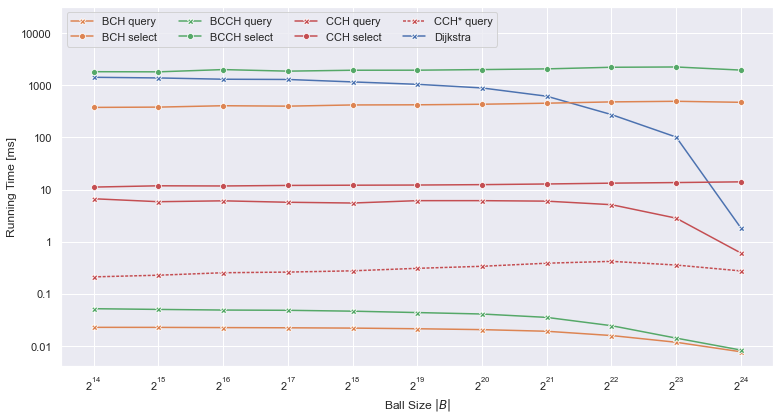

In [8]:
plt.figure(figsize=(11,6))
plot = sns.lineplot(data=times.loc[lambda x: x['algo'] != 'Dij select'], x='ball_size', y='time', hue='family', style='phase', dashes={'select': '', 'query': '', 'query*': (2,1)}, markers={'select': 'o', 'query': 'X', 'query*': 'X'}, ci=None, legend=None)
plot.set_yscale('log')
plot.set_ylim(0.004137743680123092, 32220.431221367462)
plot.set_xscale('log', base=2)
plot.set_xlabel('Ball Size $|B|$')
plot.set_ylabel('Running Time [ms]')
plot.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda val, pos: f"{val if val < 1.0 else int(val)}"))
plot.xaxis.set_major_locator(mpl.ticker.LogLocator(base=2,numticks=20))
permutation = [1,2,3,4,5,6,7,0]
plot.legend([plot.lines[idx] for idx in permutation], 
            [['Dijkstra', 'BCH query', 'BCH select', 'BCCH query', 'BCCH select', 'CCH query', 'CCH select', 'CCH* query'][idx] for idx in permutation], 
            title=None, ncol=4, loc='upper left')
plt.tight_layout()
plot.get_figure().savefig('../paper/fig/knn_ball_size.pdf')

In [9]:
times = []

for algo in ['Dij', 'BCH', 'BCCH', 'CCH*']:
    data = pd.read_csv(base + f"SEA21_improved/POIs/VaryingPOISetSize_{algo.replace('*', '')}.index.csv")
    data['phase'] = 'select'
    data['family'] = algo.replace('*', '')
    data['algo'] = algo + ' select'
    times.append(data)
    data = pd.read_csv(base + f"SEA21_improved/POIs/VaryingPOISetSize_{algo.replace('*', '')}.query.csv")
    if algo == 'CCH*':
        data['phase'] = 'query*'
    else:
        data['phase'] = 'query'
    data['family'] = algo.replace('*', '')
    data['algo'] = algo + ' query'
    times.append(data)
for algo in ['CCH']:
    data = pd.read_csv(base + f"SEA21/POIs/VaryingPOISetSize_{algo}.index.csv")
    data['phase'] = 'select'
    data['family'] = algo
    data['algo'] = algo + ' select'
    times.append(data)
    data = pd.read_csv(base + f"SEA21/POIs/VaryingPOISetSize_{algo}.query.csv")
    data['phase'] = 'query'
    data['family'] = algo
    data['algo'] = algo + ' query'
    times.append(data)
        
times = pd.concat(times, ignore_index=True)
times['time'] = times['time'] / 1000000

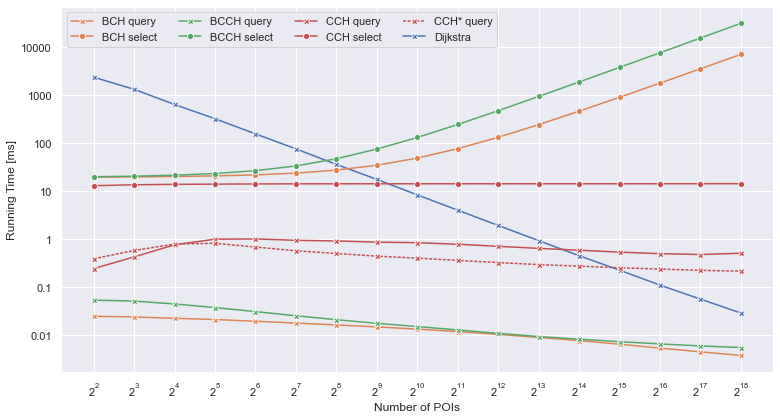

In [10]:
plt.figure(figsize=(11,6))
plot = sns.lineplot(data=times.loc[lambda x: x['algo'] != 'Dij select'], x='num_pois', y='time', hue='family', style='phase', dashes={'select': '', 'query': '', 'query*': (2,1)}, markers={'select': 'o', 'query': 'X', 'query*': 'X'}, ci=None, legend=None)
plot.set_xlabel('Number of POIs')
plot.set_ylabel('Running Time [ms]')
plot.set_yscale('log')
plot.set_xscale('log', base=2)
plot.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda val, pos: f"{val if val < 1.0 else int(val)}"))
plot.xaxis.set_major_locator(mpl.ticker.LogLocator(base=2,numticks=20))
permutation = [1,2,3,4,5,6,7,0]
plot.legend([plot.lines[idx] for idx in permutation], 
            [['Dijkstra', 'BCH query', 'BCH select', 'BCCH query', 'BCCH select', 'CCH query', 'CCH select', 'CCH* query'][idx] for idx in permutation], 
            title=None, ncol=4)
plt.tight_layout()
plot.get_figure().savefig('../paper/fig/knn_num_pois.pdf')

In [11]:
demands = []

for i in range(1, 11):
    for algo in ['Dij', 'kd-tree', 'CCH*']:
        data = pd.read_csv(base + f"SEA21_improved/TravelDemand/{algo.replace('*', '')}_{i*i}.csv", comment='#')
        data['foo'] = i
        data['algo'] = algo
        demands.append(data)
    for algo in ['CCH']:
        data = pd.read_csv(base + f"SEA21/TravelDemand/{algo}_{i*i}.csv", comment='#')
        data['foo'] = i
        data['algo'] = algo
        demands.append(data)
        
demands = pd.concat(demands, ignore_index=True)
demands['time'] = demands['calculation_time'] / 1000000

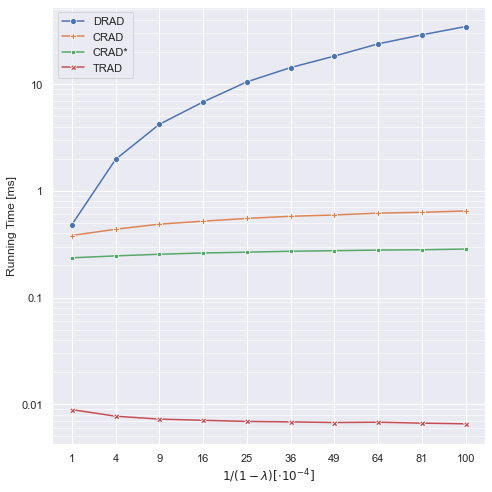

In [12]:
plt.figure(figsize=(7,7))
plot = sns.lineplot(data=demands, x='foo', y='time', hue='algo', hue_order=['Dij', 'CCH', 'CCH*', 'kd-tree'], style='algo', dashes=False, markers=True, ci=None)
plot.set_xlabel(R'$1/(1-\lambda) [\cdot 10^{-4}]$')
plot.set_ylabel('Running Time [ms]')
plot.set_yscale('log')
plt.grid(True, which="minor", linewidth=0.6)
plot.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda val, pos: f"{val if val < 1.0 else int(val)}"))
plot.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda val, pos: f"{int(val * val)}"))
plot.xaxis.set_major_locator(mpl.ticker.MaxNLocator(11))
plt.legend(labels=['DRAD', 'CRAD', 'CRAD*', 'TRAD'], title=None)
plt.tight_layout()
plot.get_figure().savefig('../paper/fig/knn_demands.pdf')